In [1]:
import math
from abc import abstractmethod
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from torchdiffeq import odeint
from torch.nn import Parameter
from torch.distributions import Independent, Normal

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.variational.models import VariationalLFM
from lafomo.variational.models import
from lafomo.plot import Plotter

import numpy as np

In [2]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_latents):
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a MultitaskVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=False
            ), num_tasks=num_latents
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents]))

    def forward(self, t):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(t)
        covar_x = self.covar_module(t)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
from lafomo.variational.trainer import Trainer
from lafomo.utilities.torch import is_cuda


class NewTrainer(Trainer):
    def __init__(self, lfm, optimizer: torch.optim.Optimizer, dataset):
        super().__init__(lfm, optimizer, dataset, batch_size=lfm.num_outputs)

    def single_epoch(self, rtol, atol):
        data = next(iter(self.data_loader))

        self.optimizer.zero_grad()
        t, y = data
        t = t.cuda() if is_cuda() else t
        y = y.cuda() if is_cuda() else y
        # Assume that the batch of t s are the same
        t, y = t[0].view(-1), y

        # with ef.scan():
        # print('fout', f_output.event_shape, f_output.batch_shape)
        # print('fout', f_output)

        output = self.lfm(t, step_size=1e-1)

        # print('gout', g_output.event_shape, g_output.batch_shape)
        # Calc loss and backprop gradients
        #  log_likelihood - kl_divergence + log_prior - added_loss
        # print(y.shape)
        log_likelihood, kl_divergence, _ = self.lfm.loss_fn(output, y.permute(1, 0))

        loss = - (log_likelihood - kl_divergence)

        loss.backward()
        self.optimizer.step()

        return loss, (-log_likelihood, kl_divergence)

    def after_epoch(self):
        with torch.no_grad():
            self.lfm.sensitivity.clamp_(0, 20)
            self.lfm.basal_rate.clamp_(0, 20)
            self.lfm.decay_rate.clamp_(0, 20)
            self.lfm.sensitivity[3] = np.float64(1.)
            self.lfm.decay_rate[3] = np.float64(0.8)

In [4]:
dataset = P53Data(replicate=0, data_dir='../data')
num_genes = 5
num_tfs = 1
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    learn_inducing=False,
    num_samples=80,
    kernel_scale=False,
    initial_conditions=False
)

# The shape of the inducing points should be (2 x m x 1) - so that we learn different inducing
# points for each output
num_inducing = 12
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)

gp_model = MultitaskGPModel(inducing_points, num_tfs)
lfm = TranscriptionalRegulationLFM(gp_model, config, dataset)

# Use the adam optimizer
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.08)

trainer = NewTrainer(lfm, optimizer, dataset)

step_size = 1e-1
plotter = Plotter(lfm, dataset.gene_names)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\torch\optim\adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [7]:
lfm.train()

trainer.train(100, report_interval=10, rtol=step_size)

Epoch 051/150 - Loss: 4.91 (4.00  0.91  ) λ: 0.755979061126709
Epoch 061/150 - Loss: 4.11 (3.09  1.01  ) λ: 0.6534603834152222
Epoch 071/150 - Loss: 3.54 (2.36  1.18  ) λ: 0.6943114995956421
Epoch 081/150 - Loss: 3.94 (2.72  1.22  ) λ: 0.7310426831245422
Epoch 091/150 - Loss: 3.86 (2.51  1.35  ) λ: 0.6849920153617859
Epoch 101/150 - Loss: 3.26 (2.05  1.21  ) λ: 0.6531664133071899
Epoch 111/150 - Loss: 2.89 (1.72  1.18  ) λ: 0.7326463460922241
Epoch 121/150 - Loss: 5.44 (4.19  1.25  ) λ: 0.7383546829223633
Epoch 131/150 - Loss: 4.51 (3.28  1.23  ) λ: 0.6027791500091553
Epoch 141/150 - Loss: 3.50 (2.41  1.09  ) λ: 0.6501431465148926


torch.Size([5, 80])
mean shaep torch.Size([1, 80])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\plot\plotter.py:110: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


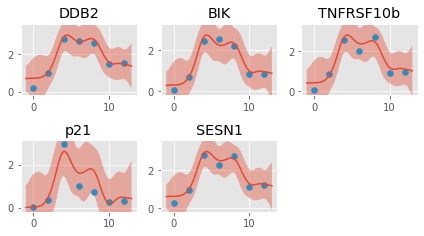

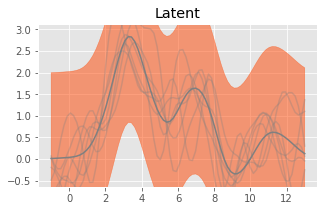

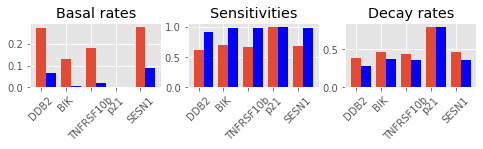

In [8]:
lfm.eval()


plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))

plotter.plot_latents(t_predict)

plotter.plot_kinetics()